# Original notebook:
https://www.kaggle.com/code/takanashihumbert/cibmtr-using-official-metric-in-tree-based-models/notebook

In [30]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, Back, Style

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder
import os, glob, math, gc, warnings, random, joblib
from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb
print("we are using xgboost ==", xgb.__version__)
from lightgbm import LGBMRegressor, callback

from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter

from tqdm import tqdm 
import pdb

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

we are using xgboost == 2.1.3


In [15]:
class ParticipantVisibleError(Exception):
    pass


def custom_score(solution, submission, row_id_column_name, prediction_label='prediction', print_info=True):
    
    del solution[row_id_column_name]
    del submission[row_id_column_name]
    
    event_label = 'efs'
    interval_label = 'efs_time'
    
    for col in submission.columns:
        if not pd.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be a number')
    # Merging solution and submission dfs on ID
    merged_df = pd.concat([solution, submission], axis=1)
    merged_df.reset_index(inplace=True)
    merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)
    metric_dict = {}
    for race in sorted(merged_df_race_dict.keys()):
        # Retrieving values from y_test based on index
        indices = sorted(merged_df_race_dict[race])
        merged_df_race = merged_df.iloc[indices]
        # Calculate the concordance index
        c_index_race = concordance_index(
                        merged_df_race[interval_label],
                        -merged_df_race[prediction_label],
                        merged_df_race[event_label])

        metric_dict[race] = c_index_race

    race_c_index = list(metric_dict.values())
    c_score = float(np.mean(race_c_index) - np.std(race_c_index))
    if print_info:
        print(f"{Fore.GREEN}{Style.BRIGHT}# c-index={c_score:.4f}, mean={np.mean(race_c_index):.4f} std={np.std(race_c_index):.4f}{Style.RESET_ALL}")
    
    return c_score, metric_dict


def display_overall(df):
    
    race_groups = [
        'American Indian or Alaska Native', 'Asian',
       'Black or African-American', 'More than one race',
       'Native Hawaiian or other Pacific Islander', 'White'
    ]
    df['mean'] = df[race_groups].mean(axis=1)
    df['std'] = np.std(df[race_groups], axis=1)
    df['score'] = df['mean'] - df['std']
    df = df.T
    df['Overall'] = df.mean(axis=1)
    temp = df.drop(index=['std']).values
    display(df
            .iloc[:len(race_groups)]
            .style
            .format(precision=4)
            .background_gradient(axis=None, vmin=temp.min(), vmax=temp.max(), cmap="cool")
            .concat(df.iloc[len(race_groups):].style.format(precision=3))
           )


# Load Train and Test

In [16]:
test = pd.read_csv("../preprocessed_data/custom_test_0.1_imbalanced.csv")
print("Test shape:", test.shape )

test_balanced = pd.read_csv("../preprocessed_data/custom_test_0.1_balanced.csv")
print("Balanced Test shape:", test_balanced.shape )

train = pd.read_csv("../preprocessed_data/custom_train_0.9_balanced.csv")
print("Train shape:",train.shape)

Test shape: (1057, 60)
Balanced Test shape: (2880, 60)
Train shape: (25920, 60)


In [17]:
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    """
    Transform using survival probability estimates
    """
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], df[event_col])
    y = kmf.survival_function_at_times(df[time_col]).values
    
    return y

# Let's substract 0.1 instead of 0.2 from the Kaplan Meier survival scores 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


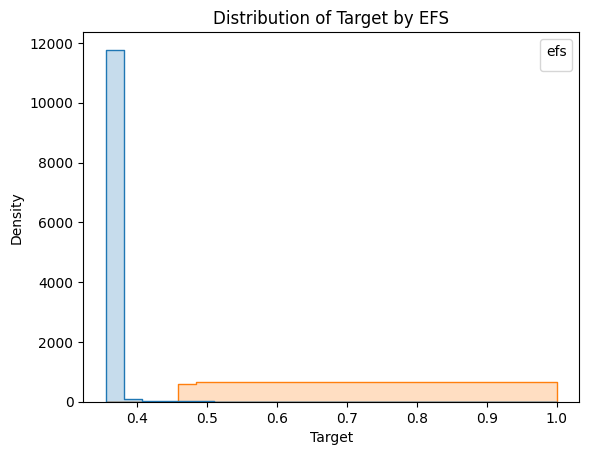

In [18]:
SUBTRACT_KP_SCORE = 0.1

train["label"] = transform_survival_probability(train, time_col='efs_time', event_col='efs')
train.loc[train['efs']==0, 'label'] -= SUBTRACT_KP_SCORE # or -0.1 according to other notebook

test['label'] = transform_survival_probability(test, time_col='efs_time', event_col='efs')
test.loc[test['efs']==0, 'label'] -= SUBTRACT_KP_SCORE # or -0.1 according to other notebook
test_balanced['label'] = transform_survival_probability(test_balanced, time_col='efs_time', event_col='efs')
test_balanced.loc[test_balanced['efs']==0, 'label'] -= SUBTRACT_KP_SCORE # or -0.1 according to other notebook

sns.histplot(data=train, x='label', hue='efs', element='step', common_norm=False)
plt.legend(title='efs')
plt.title('Distribution of Target by EFS')
plt.xlabel('Target')
plt.ylabel('Density')
plt.show()

# Let's convert year_hct to year_hct_from_baseline to avoid a big difference in scale

In [19]:
MIN_YEAR = train['year_hct'].min() # 2008
train['year_hct_relative'] = train['year_hct'] - MIN_YEAR
train.drop(columns=['year_hct'], inplace=True)

test['year_hct_relative'] = test['year_hct'] - MIN_YEAR
test.drop(columns=['year_hct'], inplace=True)   

test_balanced['year_hct_relative'] = test_balanced['year_hct'] - MIN_YEAR   
test_balanced.drop(columns=['year_hct'], inplace=True)  


In [20]:
RMV = ["ID","efs","efs_time","label",'y','kfold']
FEATURES = [c for c in train.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

There are 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10', 'year_hct_relative']


In [21]:
CAT_FEATURES = []
for c in FEATURES:
    if train[c].dtype=="object":
        CAT_FEATURES.append(c)
        train[c] = train[c].fillna("NAN")
        test[c] = test[c].fillna("NAN")
        test_balanced[c] = test_balanced[c].fillna("NAN")

In [22]:
combined = pd.concat([train, test, test_balanced], axis=0, ignore_index=True)

print("The CATEGORICAL FEATURES: ", end="")
for c in FEATURES:
    if c in CAT_FEATURES:
        print(f"{c}, ", end="")
        combined[c] = combined[c].astype("category")
    else:
        if combined[c].dtype == "float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype == "int64":
            combined[c] = combined[c].astype("int32")

train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):len(train) + len(test)].reset_index(drop=True).copy()
test_balanced = combined.iloc[len(train) + len(test):].reset_index(drop=True).copy()


The CATEGORICAL FEATURES: dri_score, psych_disturb, cyto_score, diabetes, tbi_status, arrhythmia, graft_type, vent_hist, renal_issue, pulm_severe, prim_disease_hct, cmv_status, tce_imm_match, rituximab, prod_type, cyto_score_detail, conditioning_intensity, ethnicity, obesity, mrd_hct, in_vivo_tcd, tce_match, hepatic_severe, prior_tumor, peptic_ulcer, gvhd_proph, rheum_issue, sex_match, race_group, hepatic_mild, tce_div_match, donor_related, melphalan_dose, cardiac, pulm_moderate, 

In [23]:
folds = 5
train['kfold'] = -1  

skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
groups = train['efs'].astype(str)
for fold, (train_idx, val_idx) in enumerate(skf.split(X=train, y=groups)):
    train.loc[val_idx, 'kfold'] = fold

# Custom Metrics

In [24]:
def CIndexMetric_XGB(y_true, y_pred):
    ds_pred["prediction"] = y_pred
    cindex_score, _ = custom_score(ds_true.copy(), ds_pred.copy(), "ID", print_info=False)
    return -cindex_score

def CIndexMetric_LGB(y_true, y_pred):
    ds_pred["prediction"] = y_pred
    cindex_score, _ = custom_score(ds_true.copy(), ds_pred.copy(), "ID", print_info=False)
    return ('C-Index', cindex_score, True)

# Feature selection

In [29]:
train[FEATURES]

,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,year_hct_relative
0,Intermediate,No,NAN,No,NaN,NaN,No TBI,No,NaN,Bone marrow,No,No,No,AML,NaN,NAN,NaN,NaN,NAN,NaN,NaN,No,NaN,NaN,BM,NAN,MAC,Not Hispanic or Latino,No,Negative,Yes,NAN,NaN,No,41.931999,No,NaN,No,15.262000,NaN,FK+ MMF +- others,No,F-F,NaN,American Indian or Alaska Native,1.0,90.0,No,NAN,Related,"N/A, Mel not given",NaN,No,NaN,No,NaN,1
1,N/A - pediatric,No,Poor,Yes,1.0,4.0,TBI + Cy +- Other,No,3.0,Peripheral blood,No,No,No,ALL,3.0,+/+,5.0,1.0,NAN,3.0,1.0,No,1.0,1.0,PB,Poor,MAC,Hispanic or Latino,Not done,NAN,No,NAN,1.0,No,26.260000,No,1.0,No,24.122999,1.0,Cyclophosphamide alone,No,M-M,1.0,Asian,0.0,70.0,No,NAN,Related,"N/A, Mel not given",4.0,No,1.0,No,5.0,11
2,Low,NAN,TBD,NAN,2.0,6.0,TBI + Cy +- Other,NAN,6.0,Peripheral blood,No,NAN,No,AML,4.0,-/+,7.0,1.0,NAN,4.0,1.0,NAN,2.0,NaN,PB,Poor,MAC,Not Hispanic or Latino,NAN,NAN,Yes,NAN,2.0,No,25.659000,NAN,2.0,NAN,37.915001,2.0,FK+ MMF +- others,NAN,M-F,1.0,Native Hawaiian or other Pacific Islander,4.0,70.0,NAN,NAN,Related,NAN,7.0,NAN,1.0,NAN,NaN,9
3,Intermediate,Yes,NAN,No,1.0,4.0,TBI + Cy +- Other,No,3.0,Peripheral blood,No,No,No,AI,3.0,+/-,5.0,1.0,P/P,3.0,1.0,No,1.0,1.0,PB,NAN,MAC,Not Hispanic or Latino,No,Negative,No,NAN,1.0,No,34.078999,No,1.0,No,29.034000,1.0,Cyclophosphamide alone,No,F-M,1.0,American Indian or Alaska Native,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",4.0,No,1.0,No,5.0,10
4,Intermediate,Yes,Intermediate,Yes,NaN,NaN,No TBI,No,6.0,Peripheral blood,No,No,No,AML,NaN,+/+,NaN,NaN,NAN,NaN,2.0,No,2.0,2.0,PB,Intermediate,MAC,NAN,No,Negative,No,NAN,NaN,No,62.641998,No,2.0,No,18.614000,2.0,FK+ MMF +- others,No,F-M,2.0,Native Hawaiian or other Pacific Islander,2.0,90.0,Yes,NAN,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25915,Intermediate,No,TBD,No,2.0,8.0,TBI + Cy +- Other,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NAN,MAC,Not Hispanic or Latino,No,Negative,Yes,Fully matched,2.0,No,29.011000,No,2.0,No,26.427000,2.0,FK+ MMF +- others,No,F-M,2.0,White,0.0,90.0,No,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,9
25916,Intermediate,No,Poor,No,1.0,4.0,No TBI,No,5.0,Peripheral blood,No,No,No,ALL,3.0,+/+,5.0,1.0,G/G,3.0,1.0,No,2.0,1.0,PB,Poor,NMA,Not Hispanic or Latino,No,Negative,Yes,HvG non-permissive,1.0,No,61.984001,No,1.0,No,66.959000,2.0,FK+ MTX +- others(not MMF),No,M-M,1.0,More than one race,0.0,100.0,No,HvG non-permissive,Unrelated,"N/A, Mel not given",6.0,No,1.0,Yes,7.0,3
25917,Intermediate,No,Normal,No,2.0,8.0,TBI + Cy +- Other,No,6.0,Peripheral blood,No,No,No,ALL,6.0,+/-,NaN,NaN,NAN,6.0,NaN,No,2.0,NaN,PB,Intermediate,MAC,Not Hispanic or Latino,No,Negative,No,NAN,2.0,No,53.657001,No,2.0,No,49.362999,2.0,FK+ MTX +- others(not MMF),No,F-F,2.0,Asian,0.0,100.0,No,NAN,Unrelated,"N/A, Mel not given",NaN,No,2.0,No,NaN,0
25918,N/A - pediatric,No,NAN,NAN,2.0,8.0,TBI + Cy +- Other,No,6.0,Bone marrow,NAN,NAN,No,ALL,6.0,+/-,10.0,2.0,P/P,6.0,2.0,NAN,2.0,2.0,BM,NAN,NAN,Not Hispanic or Latino,No,Negative,No,NAN,2.0,N

In [35]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from tqdm import tqdm

def feature_selection_scores(train, steps=100):
    # Extract feature matrix and labels
    X_train = train[FEATURES].copy()  # Ensure this remains a DataFrame
    y_train = train['label'].values
    
    # Initialize scores for each feature (original features only)
    scores = np.zeros(X_train.shape[1])
    
    for i in tqdm(range(steps)):
        # Create a random vector feature sampled uniformly over [0, 1)
        random_vector = np.random.rand(X_train.shape[0])
        
        # Append the random vector as a new feature to the DataFrame
        X_train_with_random = X_train.copy()
        X_train_with_random["random_feature"] = random_vector
        
        # Create a new XGBRegressor for each iteration
        model = XGBRegressor(
            tree_method="hist",
            random_state=i, 
            n_estimators=100, 
            max_depth=3,
            enable_categorical=True  # Important if categorical features are present
        )
        
        model.fit(X_train_with_random, y_train)
        
        # Retrieve feature importances
        feature_importances = model.feature_importances_
        
        # Use the random feature's importance as threshold
        threshold = feature_importances[-1]
        
        # Find indices of original features with importance greater than the random vector
        selected_idx = np.argwhere(feature_importances[:-1] > threshold).flatten()
        
        # Increment the count for those features
        scores[selected_idx] += 1

    return scores

def feature_selection(scores, threshold=42):
    return np.argwhere(scores >= threshold).flatten()

# Example usage:
scores = feature_selection_scores(train, steps=100)
features_idx = feature_selection(scores=scores, threshold=42)

# Retrieve selected feature names
selected_features = [FEATURES[i] for i in features_idx]
print("Selected features:", selected_features)


100%|██████████| 100/100 [00:21<00:00,  4.56it/s]

Selected features: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10', 'year_hct_relative']


In [36]:
len(FEATURES), len(selected_features)

(57, 55)

In [ ]:
'''
Divided into two functions to allow returning features with different threshold values without re-running the RandomForest classifier
'''
def feature_selection(scores, threshold=42):
    return np.argwhere(scores >= threshold).flatten()


scores = feature_selection_scores(train=train)

features_idx = feature_selection(scores=scores)
features_idx

In [125]:
train['race_group'].value_counts(normalize=True)

race_group
More than one race                           0.168248
Asian                                        0.167785
White                                        0.167747
Black or African-American                    0.166474
American Indian or Alaska Native             0.166319
Native Hawaiian or other Pacific Islander    0.163426
Name: proportion, dtype: float64

# XGBoost with custom weighting

In [126]:
target_props = {
    'White': 1, # ignore white
    'Black or African-American': 0.09,
    'Asian': 0.04,
    'Native Hawaiian or other Pacific Islander': 0.02,
    'American Indian or Alaska Native': 0.03,
    'More than one race': 0.005 # upweight multiracial
}

In [127]:
# Prepare out‑of‑fold DataFrame to hold predictions and metadata
oof_xgb = train[['kfold', 'ID', 'efs', 'efs_time', 'label', 'race_group']].copy()
oof_xgb['prediction'] = 0.0
feature_importances_xgb = pd.DataFrame({'feature': FEATURES})
metric_df = []

for fold in range(skf.n_splits):

    # Split the data into training and validation sets (keep full data for weighting)
    x_train_full = train[train.kfold != fold].copy()
    x_valid_full = train[train.kfold == fold].copy()
    
    y_train = x_train_full['label']
    y_valid = x_valid_full['label']

    # Compute the training set’s race distribution (should be balanced)
    train_race_props = x_train_full['race_group'].value_counts(normalize=True).to_dict()

    # Compute sample weights: if a group’s training proportion is lower than its target proportion,
    # the weight will be > 1 (upweight minority), and if higher than target, the weight < 1 (downweight majority).
    # Note: In a balanced training set, this ratio is roughly: weight = (approx. 0.167) / (target_prop)
    x_train_full['sample_weight'] = x_train_full['race_group'].apply(
        lambda r: train_race_props[r] / target_props[r]
    )
    
    # Now, select features for modeling (dropping race_group so it’s not used as a predictor)
    x_train = x_train_full[FEATURES]
    x_valid = x_valid_full[FEATURES]

    # Prepare auxiliary data for custom metric evaluation
    ds_true = oof_xgb.loc[oof_xgb.kfold == fold, ["ID", "efs", "efs_time", "race_group"]].copy().reset_index(drop=True)
    ds_pred = oof_xgb.loc[oof_xgb.kfold == fold, ["ID"]].copy().reset_index(drop=True)
    
    clf = XGBRegressor(
        tree_method="hist",
        max_depth=3,
        colsample_bytree=0.5,
        subsample=0.8,
        n_estimators=10000,
        learning_rate=0.03,
        early_stopping_rounds=100,
        objective='reg:squarederror',
        enable_categorical=True,
        min_child_weight=5,
        eval_metric=CIndexMetric_XGB,  # your custom metric
        disable_default_eval_metric=True
    )
    
    clf.fit(
        x_train, y_train,
        sample_weight=x_train_full['sample_weight'],  # apply the computed weights
        eval_set=[(x_valid, y_valid)],
        verbose=500,
    )
    
    # Record feature importances
    feature_importances_xgb[f'fold_{fold + 1}'] = feature_importances_xgb['feature'].map(clf.get_booster().get_score())
    
    preds_valid = clf.predict(x_valid)
    oof_xgb.loc[oof_xgb.kfold == fold, 'prediction'] = preds_valid

    # Save model to file (ensure you’re not using joblib or pickle if prohibited)
    clf.save_model(f"xgb/xgb_model_upweight_minority_ignore_white_upweight_multiracial_{fold}.bin")

    # Evaluate using your custom metric
    y_true = oof_xgb.loc[oof_xgb.kfold == fold, ["ID", "efs", "efs_time", "race_group"]].copy().reset_index(drop=True)
    y_pred = oof_xgb.loc[oof_xgb.kfold == fold, ["ID", "prediction"]].copy().reset_index(drop=True)
    m, metric_dict = custom_score(y_true, y_pred, "ID", print_info=True)
    metric_df.append(metric_dict)

[0]	validation_0-CIndexMetric_XGB:-0.59023
[500]	validation_0-CIndexMetric_XGB:-0.65310
[632]	validation_0-CIndexMetric_XGB:-0.65283
# c-index=0.6534, mean=0.6667 std=0.0132
[0]	validation_0-CIndexMetric_XGB:-0.58752
[500]	validation_0-CIndexMetric_XGB:-0.65216
[790]	validation_0-CIndexMetric_XGB:-0.65422
# c-index=0.6548, mean=0.6718 std=0.0169
[0]	validation_0-CIndexMetric_XGB:-0.60330
[295]	validation_0-CIndexMetric_XGB:-0.65639
# c-index=0.6572, mean=0.6678 std=0.0106
[0]	validation_0-CIndexMetric_XGB:-0.58830
[500]	validation_0-CIndexMetric_XGB:-0.64753
[574]	validation_0-CIndexMetric_XGB:-0.64726
# c-index=0.6482, mean=0.6639 std=0.0158
[0]	validation_0-CIndexMetric_XGB:-0.60045
[438]	validation_0-CIndexMetric_XGB:-0.65586
# c-index=0.6563, mean=0.6682 std=0.0118


In [128]:

def evaluate_test_set(test_set, model_prefix, skf, FEATURES, custom_score, dataset_name="test set"):
    """
    Evaluate the model on a given test set (imbalanced or balanced).
    
    Parameters:
        test_set (pd.DataFrame): The test set to evaluate.
        model_prefix (str): Prefix for the saved model filenames.
        skf (StratifiedKFold): Cross-validation object to determine the number of folds.
        FEATURES (list): List of feature columns.
        custom_score (function): Function to compute custom evaluation metric.
        dataset_name (str): Name of the dataset for logging purposes.
    
    Returns:
        None (prints evaluation results)
    """
    print(f"Evaluating on {dataset_name}...")

    # Ensure the test set has the required feature columns
    if not set(FEATURES).issubset(test_set.columns):
        raise ValueError(f"{dataset_name} does not have all required feature columns.")

    # Initialize an array to accumulate predictions from each fold
    test_predictions = np.zeros(len(test_set))

    # Initialize a dictionary to store the evaluation metric for each fold
    metric_df = []

    # Loop over folds, load each saved model, and predict on the test set
    for fold in range(skf.n_splits):
        model_filename = f"xgb/{model_prefix}_{fold}.bin"
        clf = XGBRegressor()  # We only use this to load the saved booster
        clf.load_model(model_filename)
        fold_pred = clf.predict(test_set[FEATURES])
        test_set[f'prediction_{fold}'] = fold_pred

        # If labels exist, compute the custom metric for this fold
        if "label" in test_set.columns:
            y_true_test = test_set[["ID", "efs", "efs_time", "race_group"]].copy().reset_index(drop=True)
            y_pred_test = test_set[["ID", f"prediction_{fold}"]].copy().reset_index(drop=True)
            m, metric_dict = custom_score(y_true_test, y_pred_test, "ID", print_info=True, prediction_label=f"prediction_{fold}")
            print(f"{dataset_name} evaluation metric for fold {fold}:", metric_dict)
            metric_df.append(metric_dict)

        test_predictions += fold_pred

    # Average the predictions across folds
    test_predictions /= skf.n_splits
    test_set['ensemble_prediction'] = test_predictions

    print('\nENSEMBLE:')
    # If labels exist, compute the custom metric for an ensemble
    if "label" in test_set.columns:
        y_true_test = test_set[["ID", "efs", "efs_time", "race_group"]].copy().reset_index(drop=True)
        y_pred_test = test_set[["ID", "ensemble_prediction"]].copy().reset_index(drop=True)
        m, ensemble_metric_dict = custom_score(y_true_test, y_pred_test, "ID", print_info=True, prediction_label="ensemble_prediction")
        print(f"{dataset_name} evaluation metric:", metric_dict)
    else:
        print(f"{dataset_name} predictions computed. No labels available for evaluation.")
    return ensemble_metric_dict, metric_df


# Evaluation on full test set

## upweight minority and ignore white

In [40]:
ensemble_balanced_metric_dict, balanced_metric_dicts = evaluate_test_set(test_balanced, 
                                                                         "xgb_model_upweight_minority_ignore_white", skf, FEATURES, custom_score, dataset_name="balanced test set")


Evaluating on balanced test set...
# c-index=0.6546, mean=0.6657 std=0.0111
balanced test set evaluation metric for fold 0: {'American Indian or Alaska Native': 0.6852392464534963, 'Asian': 0.6699527924558063, 'Black or African-American': 0.6523944502461584, 'More than one race': 0.6659624603883968, 'Native Hawaiian or other Pacific Islander': 0.6529193004271585, 'White': 0.6679261620813162}
# c-index=0.6534, mean=0.6671 std=0.0137
balanced test set evaluation metric for fold 1: {'American Indian or Alaska Native': 0.6915568124800437, 'Asian': 0.6676205820385998, 'Black or African-American': 0.6535666332772107, 'More than one race': 0.6682608039559368, 'Native Hawaiian or other Pacific Islander': 0.6493270238218599, 'White': 0.6720588814106349}
# c-index=0.6583, mean=0.6680 std=0.0096
balanced test set evaluation metric for fold 2: {'American Indian or Alaska Native': 0.6834032750992108, 'Asian': 0.6704935948713904, 'Black or African-American': 0.657019245114128, 'More than one race': 

In [41]:
display_overall(pd.DataFrame(balanced_metric_dicts))

,0,1,2,3,4,Overall
American Indian or Alaska Native,0.6852,0.6916,0.6834,0.6868,0.6943,0.6883
Asian,0.6700,0.6676,0.6705,0.6671,0.6692,0.6689
Black or African-American,0.6524,0.6536,0.6570,0.6477,0.6534,0.6528
More than one race,0.6660,0.6683,0.6657,0.6639,0.6691,0.6666
Native Hawaiian or other Pacific Islander,0.6529,0.6493,0.6562,0.6562,0.6527,0.6535
White,0.6679,0.6721,0.6750,0.6706,0.6701,0.6711
mean,0.666,0.667,0.668,0.665,0.668,0.667
std,0.011,0.014,0.010,0.012,0.014,0.012
score,0.655,0.653,0.658,0.653,0.654,0.655


## upweight minority and ignore white and upweight multiracial

In [93]:
ensemble_balanced_metric_dict, balanced_metric_dicts = evaluate_test_set(test_balanced, 
                                                                         "xgb_model_upweight_minority_ignore_white_upweight_multiracial", skf, FEATURES, custom_score, dataset_name="balanced test set")


Evaluating on balanced test set...
# c-index=0.6503, mean=0.6602 std=0.0099
balanced test set evaluation metric for fold 0: {'American Indian or Alaska Native': 0.6756374583770469, 'Asian': 0.6639476322994242, 'Black or African-American': 0.6555486882206262, 'More than one race': 0.6647552496256486, 'Native Hawaiian or other Pacific Islander': 0.643201731661543, 'White': 0.6581453930019286}
# c-index=0.6486, mean=0.6621 std=0.0135
balanced test set evaluation metric for fold 1: {'American Indian or Alaska Native': 0.6822629202207727, 'Asian': 0.6602521491262661, 'Black or African-American': 0.6607915432322414, 'More than one race': 0.6688760171331066, 'Native Hawaiian or other Pacific Islander': 0.636938275016407, 'White': 0.663311292163577}
# c-index=0.6481, mean=0.6609 std=0.0128
balanced test set evaluation metric for fold 2: {'American Indian or Alaska Native': 0.6808032659763719, 'Asian': 0.6612098200705296, 'Black or African-American': 0.6496558044372456, 'More than one race': 0.

In [71]:
display_overall(pd.DataFrame(balanced_metric_dicts))

,0,1,2,3,4,Overall
American Indian or Alaska Native,0.6783,0.6849,0.6813,0.6870,0.6848,0.6833
Asian,0.6658,0.6651,0.6638,0.6673,0.6684,0.6661
Black or African-American,0.6546,0.6578,0.6514,0.6514,0.6517,0.6534
More than one race,0.6682,0.6660,0.6585,0.6581,0.6654,0.6633
Native Hawaiian or other Pacific Islander,0.6432,0.6389,0.6480,0.6409,0.6386,0.6419
White,0.6595,0.6639,0.6712,0.6669,0.6633,0.6649
mean,0.662,0.663,0.662,0.662,0.662,0.662
std,0.011,0.014,0.011,0.014,0.014,0.013
score,0.651,0.649,0.651,0.647,0.648,0.649


In [43]:
# ensemble_balanced_metric_dict, balanced_metric_dicts = evaluate_test_set(test_balanced, 
#                                                                          "xgb_model_downweight_majority", skf, FEATURES, custom_score, dataset_name="balanced test set")


Evaluating on balanced test set...
# c-index=0.6552, mean=0.6668 std=0.0116
balanced test set evaluation metric for fold 0: {'American Indian or Alaska Native': 0.687531359759157, 'Asian': 0.6699753258897889, 'Black or African-American': 0.6549519404957269, 'More than one race': 0.6631998049890306, 'Native Hawaiian or other Pacific Islander': 0.6531726019826604, 'White': 0.6718719250600228}
# c-index=0.6543, mean=0.6672 std=0.0129
balanced test set evaluation metric for fold 1: {'American Indian or Alaska Native': 0.6906787392236464, 'Asian': 0.667361447547799, 'Black or African-American': 0.6551970333113105, 'More than one race': 0.6680634714274106, 'Native Hawaiian or other Pacific Islander': 0.6504323397004134, 'White': 0.6716062502459952}
# c-index=0.6554, mean=0.6666 std=0.0112
balanced test set evaluation metric for fold 2: {'American Indian or Alaska Native': 0.6830383615381107, 'Asian': 0.6690401883795081, 'Black or African-American': 0.6528633234585793, 'More than one race': 0

# Evaluation on imbalanced test subset

## upweight minority ignore white

In [27]:
ensemble_imbalanced_metric_dict, imbalanced_metric_dicts = evaluate_test_set(test, "xgb_model_upweight_minority_ignore_white", skf, FEATURES, custom_score, dataset_name="imbalanced test set")


Evaluating on imbalanced test set...
# c-index=0.5780, mean=0.6338 std=0.0558
imbalanced test set evaluation metric for fold 0: {'American Indian or Alaska Native': 0.6842818428184282, 'Asian': 0.6410490307867731, 'Black or African-American': 0.6406561737973842, 'More than one race': 0.5137686860739575, 'Native Hawaiian or other Pacific Islander': 0.6549925484351714, 'White': 0.6679261620813162}
# c-index=0.5895, mean=0.6402 std=0.0507
imbalanced test set evaluation metric for fold 1: {'American Indian or Alaska Native': 0.6907181571815718, 'Asian': 0.6474344355758267, 'Black or African-American': 0.6372940220202468, 'More than one race': 0.5334382376081825, 'Native Hawaiian or other Pacific Islander': 0.6602086438152012, 'White': 0.6720588814106349}
# c-index=0.5820, mean=0.6373 std=0.0553
imbalanced test set evaluation metric for fold 2: {'American Indian or Alaska Native': 0.6747967479674797, 'Asian': 0.6419612314709237, 'Black or African-American': 0.6482302519766496, 'More than on

In [45]:
display_overall(pd.DataFrame(imbalanced_metric_dicts))

,0,1,2,3,4,Overall
American Indian or Alaska Native,0.6843,0.6907,0.6748,0.6870,0.6789,0.6831
Asian,0.6410,0.6474,0.6420,0.6481,0.6474,0.6452
Black or African-American,0.6407,0.6373,0.6482,0.6370,0.6411,0.6408
More than one race,0.5138,0.5334,0.5169,0.5161,0.5264,0.5213
Native Hawaiian or other Pacific Islander,0.6550,0.6602,0.6669,0.6721,0.6565,0.6621
White,0.6679,0.6721,0.6750,0.6706,0.6701,0.6711
mean,0.634,0.640,0.637,0.638,0.637,0.637
std,0.056,0.051,0.055,0.057,0.051,0.054
score,0.578,0.589,0.582,0.581,0.586,0.583


# upweight minority + ignore white + upweight multiracial

In [94]:
ensemble_imbalanced_metric_dict, imbalanced_metric_dicts = evaluate_test_set(test, 
                                                                             "xgb_model_upweight_minority_ignore_white_upweight_multiracial", skf, FEATURES, custom_score, dataset_name="imbalanced test set")


Evaluating on imbalanced test set...
# c-index=0.5829, mean=0.6325 std=0.0496
imbalanced test set evaluation metric for fold 0: {'American Indian or Alaska Native': 0.6849593495934959, 'Asian': 0.6478905359179019, 'Black or African-American': 0.6447942067538609, 'More than one race': 0.5279307631785995, 'Native Hawaiian or other Pacific Islander': 0.6311475409836066, 'White': 0.6581453930019286}
# c-index=0.5880, mean=0.6345 std=0.0466
imbalanced test set evaluation metric for fold 1: {'American Indian or Alaska Native': 0.681910569105691, 'Asian': 0.6449258836944127, 'Black or African-American': 0.6493386536614202, 'More than one race': 0.5365853658536586, 'Native Hawaiian or other Pacific Islander': 0.6311475409836066, 'White': 0.663311292163577}
# c-index=0.5774, mean=0.6339 std=0.0565
imbalanced test set evaluation metric for fold 2: {'American Indian or Alaska Native': 0.684620596205962, 'Asian': 0.6399087799315849, 'Black or African-American': 0.6394738786669623, 'More than one r

In [95]:
display_overall(pd.DataFrame(imbalanced_metric_dicts))

,0,1,2,3,4,Overall
American Indian or Alaska Native,0.6850,0.6819,0.6846,0.6941,0.6900,0.6871
Asian,0.6479,0.6449,0.6399,0.6470,0.6317,0.6423
Black or African-American,0.6448,0.6493,0.6395,0.6362,0.6410,0.6422
More than one race,0.5279,0.5366,0.5130,0.5208,0.5177,0.5232
Native Hawaiian or other Pacific Islander,0.6311,0.6311,0.6535,0.6535,0.6468,0.6432
White,0.6581,0.6633,0.6728,0.6668,0.6629,0.6648
mean,0.632,0.635,0.634,0.636,0.632,0.634
std,0.050,0.047,0.057,0.055,0.054,0.052
score,0.583,0.588,0.577,0.582,0.577,0.581


In [46]:
# ensemble_imbalanced_metric_dict, imbalanced_metric_dicts = evaluate_test_set(test, 
#                                                                              "xgb_model_downweight_majority", skf, FEATURES, custom_score, dataset_name="imbalanced test set")


Evaluating on imbalanced test set...
# c-index=0.5733, mean=0.6343 std=0.0609
imbalanced test set evaluation metric for fold 0: {'American Indian or Alaska Native': 0.6832655826558266, 'Asian': 0.6483466362599772, 'Black or African-American': 0.6458656617158058, 'More than one race': 0.5011801730920535, 'Native Hawaiian or other Pacific Islander': 0.6549925484351714, 'White': 0.6718719250600228}
# c-index=0.5935, mean=0.6410 std=0.0475
imbalanced test set evaluation metric for fold 1: {'American Indian or Alaska Native': 0.6876693766937669, 'Asian': 0.6501710376282782, 'Black or African-American': 0.6393999852213109, 'More than one race': 0.5405192761605035, 'Native Hawaiian or other Pacific Islander': 0.6564828614008942, 'White': 0.6716062502459952}
# c-index=0.5793, mean=0.6357 std=0.0564
imbalanced test set evaluation metric for fold 2: {'American Indian or Alaska Native': 0.6744579945799458, 'Asian': 0.6433295324971494, 'Black or African-American': 0.6443877928027784, 'More than on

In [47]:
display_overall(pd.DataFrame(imbalanced_metric_dicts))

,0,1,2,3,4,Overall
American Indian or Alaska Native,0.6833,0.6877,0.6745,0.6941,0.6839,0.6847
Asian,0.6483,0.6502,0.6433,0.6481,0.6447,0.6469
Black or African-American,0.6459,0.6394,0.6444,0.6361,0.6425,0.6417
More than one race,0.5012,0.5405,0.5130,0.5161,0.5256,0.5193
Native Hawaiian or other Pacific Islander,0.6550,0.6565,0.6632,0.6468,0.6565,0.6556
White,0.6719,0.6716,0.6760,0.6709,0.6705,0.6722
mean,0.634,0.641,0.636,0.635,0.637,0.637
std,0.061,0.048,0.056,0.057,0.052,0.055
score,0.573,0.593,0.579,0.579,0.585,0.582


In [45]:
test['race_group'].value_counts(normalize=True)

race_group
White                                        0.456954
Black or African-American                    0.245033
Asian                                        0.108798
American Indian or Alaska Native             0.081362
More than one race                           0.053926
Native Hawaiian or other Pacific Islander    0.053926
Name: proportion, dtype: float64

In [ ]:
# For inference:
# model_path = f"./xxx/xgb_model.bin"
# model = XGBRegressor()
# model.load_model(model_path)
# prediction = model.predict()

# Lightgbm

In [ ]:
%%time
    
oof_lgb = train[['kfold','ID','efs','efs_time','label','race_group']].copy()
oof_lgb['prediction'] = 0.0
feature_importances_lgb = pd.DataFrame()
feature_importances_lgb['feature'] = FEATURES
metric_df = []

for fold in range(skf.n_splits):
    
    x_train = train[train.kfold != fold].copy()
    x_valid = train[train.kfold == fold].copy()

    y_train = x_train['label']
    y_valid = x_valid['label']
    y_label = x_valid['efs']

    x_train = x_train[FEATURES]
    x_valid = x_valid[FEATURES]

    ds_true = oof_lgb.loc[oof_lgb.kfold==fold, ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
    ds_pred = oof_lgb.loc[oof_lgb.kfold==fold, ["ID"]].copy().reset_index(drop=True)

    lgb_params = {
        'max_depth': 6,
        'num_leaves': 40,
        'learning_rate': 0.03,
        'n_estimators': 10000,
        'objective': 'l2',
        'subsample': 0.8,
        'colsample_bytree': 0.5,
        'n_jobs': -1,
        'verbose': -1,
        'device': 'gpu',
        'metric': 'None' # only show the custom metric
    }
    clf = LGBMRegressor(**lgb_params)
    clf.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        categorical_feature=CAT_FEATURES,
        eval_metric=CIndexMetric_LGB, # the custom metric
        callbacks=[callback.log_evaluation(500), callback.early_stopping(100)]
    )
    feature_importances_lgb[f'fold_{fold + 1}'] = clf.feature_importances_

    preds_valid = clf.predict(x_valid)
    oof_lgb.loc[oof_lgb.kfold==fold, 'prediction'] = preds_valid

    joblib.dump(clf, f"lgb_model_{fold}.pkl")

    y_true = oof_lgb.loc[oof_lgb.kfold==fold, ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
    y_pred = oof_lgb.loc[oof_lgb.kfold==fold, ["ID","prediction"]].copy().reset_index(drop=True)
    m, metric_dict = custom_score(y_true, y_pred, "ID", print_info=True)
    metric_df.append(metric_dict)

In [ ]:
# For inference:
# model_path = f"./xxx/lgb_model.pkl"
# model = joblib.load(model_path)
# prediction = model.predict()

In [ ]:
y_true = oof_lgb[["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
y_pred = oof_lgb[["ID","prediction"]].copy().reset_index(drop=True)
m, _ = custom_score(y_true, y_pred, "ID", print_info=True)
print(f"Overall official SCORE: {m:.5f}")

metric_df_ = pd.DataFrame(metric_df)
display_overall(metric_df_)

In [ ]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = 0.5*oof_xgb['prediction'].rank(pct=True) + 0.5*oof_lgb['prediction'].rank(pct=True)

m, _ = custom_score(y_true, y_pred, "ID", print_info=True)
print(f"Overall official SCORE: {m:.5f}")